# FDA Recalls Data Preprocessing
- This notebook preprocesses the FDA recall data to create the final dataset for modeling

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re

# Import NLTK resources
nltk.download('stopwords', quiet=True)

True

In [2]:
# Load the data
file_path = '../data/recalls_details.xlsx'
df = pd.read_excel(file_path)

In [3]:
# Display basic information
print(f"Original data shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

Original data shape: (95082, 17)

Column names:
['FEI Number', 'Recalling Firm Name', 'Product Type', 'Product Classification', 'Status', 'Distribution Pattern', 'Recalling Firm City', 'Recalling Firm State', 'Recalling Firm Country', 'Center Classification Date', 'Reason for Recall', 'Product Description', 'Event ID', 'Event Classification', 'Product ID', 'Center', 'Recall Details']


In [4]:
# Create a copy of the original dataframe to work with
df_processed = df.copy()

# Step 1: Feature engineering for 'Center Classification Date'

In [5]:
# Confirm datetime format
df_processed['Center Classification Date'] = pd.to_datetime(df_processed['Center Classification Date'], errors='coerce')

In [6]:
# Extract temporal features
df_processed['Classification Year'] = df_processed['Center Classification Date'].dt.year
df_processed['Classification Month'] = df_processed['Center Classification Date'].dt.month
df_processed['Classification Day'] = df_processed['Center Classification Date'].dt.day
df_processed['Classification DayOfWeek'] = df_processed['Center Classification Date'].dt.dayofweek

Add cyclical encoding for month, day, and day of week. Reference https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/

In [7]:
# Month (1-12) -> sin and cos
df_processed['Month_sin'] = np.sin(2 * np.pi * df_processed['Classification Month']/12)
df_processed['Month_cos'] = np.cos(2 * np.pi * df_processed['Classification Month']/12)

# Day (1-31) -> sin and cos
df_processed['Day_sin'] = np.sin(2 * np.pi * df_processed['Classification Day']/31)
df_processed['Day_cos'] = np.cos(2 * np.pi * df_processed['Classification Day']/31)

# Day of week (0-6) -> sin and cos
df_processed['DayOfWeek_sin'] = np.sin(2 * np.pi * df_processed['Classification DayOfWeek']/7)
df_processed['DayOfWeek_cos'] = np.cos(2 * np.pi * df_processed['Classification DayOfWeek']/7)

Standardize year (continuous variable)

In [8]:
# Create a reference to the min year to create a more interpretable "years since" feature
min_year = df_processed['Classification Year'].min()
df_processed['Years_Since_First'] = df_processed['Classification Year'] - min_year

# Advanced Standardization
year_range = df_processed['Classification Year'].max() - min_year
if year_range > 10:
    scaler = StandardScaler()
    df_processed['Year_Scaled'] = scaler.fit_transform(df_processed[['Years_Since_First']])

In [9]:
# Drop original temporal columns after creating transformed versions
df_processed = df_processed.drop(columns=['Classification Month', 
                                         'Classification Day',
                                         'Classification DayOfWeek',
                                         'Classification Year'])

# Step 2: Verify relationship between Center and Product Type

In [10]:
center_product_crosstab = pd.crosstab(df['Center'], df['Product Type'])
print("\nCrosstab of Center vs Product Type (from original data):")
print(center_product_crosstab)


Crosstab of Center vs Product Type (from original data):
Product Type  Biologics  Devices  Drugs  Food/Cosmetics  Tobacco  Veterinary
Center                                                                      
CBER              12051        0      0               0        0           0
CDER                  0        0  16702               0        0           0
CDRH                  0    35475      0               0        0           0
CFSAN                 0        0      0           27435        0           0
CTP                   0        0      0               0        9           0
CVM                   0        0      0               0        0        3410


# Step 3: Feature engineering for 'Recalling Firm Name' and 'Distribution Pattern'

In [11]:
# Check cardinality
print(f"Cardinality of 'Recalling Firm Name': {df_processed['Recalling Firm Name'].nunique()}")
print(f"Cardinality of 'Distribution Pattern': {df_processed['Distribution Pattern'].nunique()}")

Cardinality of 'Recalling Firm Name': 9927
Cardinality of 'Distribution Pattern': 20312


Frequency-based encoding for 'Recalling Firm Name'

In [12]:
# Count how many times each firm has issued a recall
firm_counts = df_processed.groupby('Recalling Firm Name').size().reset_index(name='Firm_Recall_Count')

# Calculate class proportions for each firm
for prod_class in df_processed['Product Classification'].unique():
    class_prop = df_processed.groupby('Recalling Firm Name')['Product Classification'].apply(
        lambda x: (x == prod_class).mean()
    ).reset_index(name=f'Firm_Prop_{prod_class.replace(" ", "_")}')
    
    # Merge back to firm_counts
    firm_counts = pd.merge(firm_counts, class_prop, on='Recalling Firm Name', how='left')

In [13]:
# Add categorical size based on recall frequency
try:
    # Check if we have enough unique values for 5 bins
    unique_count_values = firm_counts['Firm_Recall_Count'].nunique()
    if unique_count_values >= 5:
        firm_counts['Firm_Size_Category'] = pd.qcut(
            firm_counts['Firm_Recall_Count'], 
            q=5, 
            labels=['Very Low Volume', 'Low Volume', 'Medium Volume', 'High Volume', 'Very High Volume'],
            duplicates='drop'  # Handle any duplicate bin edges
        )
    else:
        # Not enough unique values for 5 quantiles
        firm_counts['Firm_Size_Category'] = pd.cut(
            firm_counts['Firm_Recall_Count'],
            bins=[0, 1, 2, 5, 10, float('inf')],
            labels=['Very Low Volume', 'Low Volume', 'Medium Volume', 'High Volume', 'Very High Volume']
        )
except ValueError:
    # If either method fails, use a simple categorical approach
    firm_counts['Firm_Size_Category'] = 'Medium Volume'  # Default value
    
    # Assign categories based on count thresholds
    firm_counts.loc[firm_counts['Firm_Recall_Count'] == 1, 'Firm_Size_Category'] = 'Very Low Volume'
    firm_counts.loc[(firm_counts['Firm_Recall_Count'] > 1) & (firm_counts['Firm_Recall_Count'] <= 3), 'Firm_Size_Category'] = 'Low Volume'
    firm_counts.loc[(firm_counts['Firm_Recall_Count'] > 3) & (firm_counts['Firm_Recall_Count'] <= 10), 'Firm_Size_Category'] = 'Medium Volume'
    firm_counts.loc[(firm_counts['Firm_Recall_Count'] > 10) & (firm_counts['Firm_Recall_Count'] <= 30), 'Firm_Size_Category'] = 'High Volume'
    firm_counts.loc[firm_counts['Firm_Recall_Count'] > 30, 'Firm_Size_Category'] = 'Very High Volume'

Frequency-based encoding for 'Distribution Pattern'

In [14]:
# Handle missing values in Distribution Pattern
df_processed['Distribution Pattern'] = df_processed['Distribution Pattern'].fillna('Unknown')
distribution_counts = df_processed.groupby('Distribution Pattern').size().reset_index(name='Distribution_Pattern_Count')

In [15]:
# Calculate class proportions for each distribution pattern
for prod_class in df_processed['Product Classification'].unique():
    class_prop = df_processed.groupby('Distribution Pattern')['Product Classification'].apply(
        lambda x: (x == prod_class).mean()
    ).reset_index(name=f'Distribution_Prop_{prod_class.replace(" ", "_")}')
    
    # Merge back to distribution_counts
    distribution_counts = pd.merge(distribution_counts, class_prop, on='Distribution Pattern', how='left')

In [16]:
# Merge the new features back to the dataframe
df_processed = pd.merge(df_processed, firm_counts, on='Recalling Firm Name', how='left')
df_processed = pd.merge(df_processed, distribution_counts, on='Distribution Pattern', how='left')

print("Encoded high cardinality variables with frequency-based features")
print("Preview of new features:")
display(df_processed[['Firm_Recall_Count', 'Firm_Prop_Class_I', 'Firm_Size_Category', 
                     'Distribution_Pattern_Count', 'Distribution_Prop_Class_I']].head())

Encoded high cardinality variables with frequency-based features
Preview of new features:


,Firm_Recall_Count,Firm_Prop_Class_I,Firm_Size_Category,Distribution_Pattern_Count,Distribution_Prop_Class_I
0,1,1.0,Very Low Volume,1,1.000000
1,18,0.0,High Volume,4894,0.124029
2,18,0.0,High Volume,4894,0.124029
3,18,0.0,High Volume,4894,0.124029
4,18,0.0,High Volume,4894,0.124029


# Step 4: Feature engineering for geographical variables (city and state)

Create state-level aggregation features

In [17]:
# count the number of recalls associated with each state
state_counts = df_processed.groupby('Recalling Firm State').size().reset_index(name='State_Recall_Count')

# Calculate class proportions by state for each classification type
for prod_class in df_processed['Product Classification'].unique():
    class_name = prod_class.replace(' ', '_')
    state_prop = df_processed.groupby('Recalling Firm State')['Product Classification'].apply(
        lambda x: (x == prod_class).mean()
    ).reset_index(name=f'State_Prop_{class_name}')
    
    # Merge back to state_counts
    state_counts = pd.merge(state_counts, state_prop, on='Recalling Firm State', how='left')

Create city-level features with aggregation to reduce cardinality

In [18]:
# count the number of recalls associated with each city
city_counts = df_processed.groupby('Recalling Firm City').size().reset_index(name='City_Recall_Count')

# Categorize cities into frequency buckets
try:
    # First, check if we have enough unique values for 5 bins
    unique_count_values = city_counts['City_Recall_Count'].nunique()
    if unique_count_values >= 5:
        city_counts['City_Size_Category'] = pd.qcut(
            city_counts['City_Recall_Count'], 
            q=5, 
            labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'],
            duplicates='drop'
        )
    else:
        # Not enough unique values for 5 quantiles
        city_counts['City_Size_Category'] = pd.cut(
            city_counts['City_Recall_Count'],
            bins=[0, 1, 2, 5, 10, float('inf')],
            labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
        )
except ValueError:
    # If either method fails, use a simple categorical approach
    city_counts['City_Size_Category'] = 'Medium'  # Default value
    
    # Assign categories based on count thresholds
    city_counts.loc[city_counts['City_Recall_Count'] == 1, 'City_Size_Category'] = 'Very Small'
    city_counts.loc[(city_counts['City_Recall_Count'] > 1) & (city_counts['City_Recall_Count'] <= 3), 'City_Size_Category'] = 'Small'
    city_counts.loc[(city_counts['City_Recall_Count'] > 3) & (city_counts['City_Recall_Count'] <= 10), 'City_Size_Category'] = 'Medium'
    city_counts.loc[(city_counts['City_Recall_Count'] > 10) & (city_counts['City_Recall_Count'] <= 30), 'City_Size_Category'] = 'Large'
    city_counts.loc[city_counts['City_Recall_Count'] > 30, 'City_Size_Category'] = 'Very Large'

Create location-based risk scores for all classes

In [19]:
# Calculate proportion of recall events that belong to a specific classification for each city
city_class_props = {}
for prod_class in df_processed['Product Classification'].unique():
    class_name = prod_class.replace(' ', '_')
    city_risk = df_processed.groupby('Recalling Firm City')['Product Classification'].apply(
        lambda x: (x == prod_class).mean()
    ).reset_index(name=f'City_{class_name}_Risk')
    city_class_props[class_name] = city_risk

In [20]:
# Merge geographical features to df_processed
df_processed = pd.merge(df_processed, state_counts, on='Recalling Firm State', how='left')
df_processed = pd.merge(df_processed, city_counts, on='Recalling Firm City', how='left')

In [21]:
# Merge city risk scores
for class_name, risk_df in city_class_props.items():
    df_processed = pd.merge(df_processed, risk_df, on='Recalling Firm City', how='left')

Fill missing values with overall proportions where appropriate

In [22]:
# Fill in missing city risk values
for prod_class in df_processed['Product Classification'].unique():
    class_name = prod_class.replace(' ', '_')
    overall_prop = df_processed['Product Classification'].value_counts(normalize=True).get(prod_class, 0)
    df_processed.fillna({f'City_{class_name}_Risk': overall_prop}, inplace=True)

In [23]:
# Fill any other missing numerical values
numerical_cols = df_processed.select_dtypes(include=['number']).columns
for col in numerical_cols:
    if df_processed[col].isna().any():
        if col.startswith('City_') or col.startswith('State_'):
            df_processed[col].fillna(0, inplace=True)

Create regional features

In [24]:
# Define regions based on states
northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 
             'New York', 'New Jersey', 'Pennsylvania']
midwest = ['Ohio', 'Michigan', 'Indiana', 'Wisconsin', 'Illinois', 'Minnesota', 
           'Iowa', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas']
south = ['Delaware', 'Maryland', 'Virginia', 'West Virginia', 'Kentucky', 'North Carolina', 
         'South Carolina', 'Tennessee', 'Georgia', 'Florida', 'Alabama', 'Mississippi', 
         'Arkansas', 'Louisiana', 'Texas', 'Oklahoma']
west = ['Montana', 'Idaho', 'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'Utah', 
        'Nevada', 'California', 'Oregon', 'Washington', 'Alaska', 'Hawaii']

In [25]:
# Function to map states to regions
def get_region(state):
    if state in northeast:
        return 'Northeast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in west:
        return 'West'
    else:
        return 'Other'

In [26]:
# Apply the mapping function to create the region column
df_processed['Region'] = df_processed['Recalling Firm State'].apply(get_region)

In [27]:
# Create one-hot encoded region features
region_dummies = pd.get_dummies(df_processed['Region'], prefix='Region')
df_processed = pd.concat([df_processed, region_dummies], axis=1)

In [28]:
# new geographical features
geo_feature_cols = [col for col in df_processed.columns if col.startswith(('State_', 'City_', 'Region_'))]
display(df_processed[geo_feature_cols].head())

,State_Recall_Count,State_Prop_Class_I,State_Prop_Class_II,State_Prop_Class_III,City_Recall_Count,City_Size_Category,City_Class_I_Risk,City_Class_II_Risk,City_Class_III_Risk,Region_Midwest,Region_Northeast,Region_Other,Region_South,Region_West
0,1474,0.130936,0.787653,0.081411,446,Very Large,0.224215,0.730942,0.044843,False,False,False,False,True
1,4559,0.112744,0.826058,0.061198,308,Very Large,0.029221,0.753247,0.217532,False,True,False,False,False
2,4559,0.112744,0.826058,0.061198,308,Very Large,0.029221,0.753247,0.217532,False,True,False,False,False
3,4559,0.112744,0.826058,0.061198,308,Very Large,0.029221,0.753247,0.217532,False,True,False,False,False
4,4559,0.112744,0.826058,0.061198,308,Very Large,0.029221,0.753247,0.217532,False,True,False,False,False


# Step 5: Feature engineering for 'Recalling Firm Country'

Preview of new country feature

In [29]:
# Create binary US indicator
df_processed['Is_US'] = (df_processed['Recalling Firm Country'] == 'United States').astype(int)

display(df_processed[['Is_US']].head())

,Is_US
0,1
1,1
2,1
3,1
4,1


# Step 6: Create dummy variables for remaining categorical features

Create dummy variables for categorical features

In [30]:
# Product Classification
product_class_dummies = pd.get_dummies(df_processed['Product Classification'], prefix='ProdClass', drop_first=True)
df_processed = pd.concat([df_processed, product_class_dummies], axis=1)

In [31]:
# Product Type
product_type_dummies = pd.get_dummies(df_processed['Product Type'], prefix='ProductType', drop_first=True)
df_processed = pd.concat([df_processed, product_type_dummies], axis=1)

In [32]:
# Status
status_dummies = pd.get_dummies(df_processed['Status'], prefix='Status', drop_first=True)
df_processed = pd.concat([df_processed, status_dummies], axis=1)

In [33]:
# Firm Size Category
firm_size_dummies = pd.get_dummies(df_processed['Firm_Size_Category'], prefix='FirmSize', drop_first=True)
df_processed = pd.concat([df_processed, firm_size_dummies], axis=1)

In [34]:
# City Size Category
city_size_dummies = pd.get_dummies(df_processed['City_Size_Category'], prefix='CitySize', drop_first=True)
df_processed = pd.concat([df_processed, city_size_dummies], axis=1)

# Step 7: Perform correlation analysis before text processing

In [35]:
# Exclude text columns (for now) and ID variables
text_cols = ['Reason for Recall', 'Product Description']
id_cols = ["FEI Number", "Event ID", "Product ID", "Recall Details"]

In [36]:
# List of columns to drop for correlation analysis (excluding text columns we'll need later)
correlation_drop_cols = [
    # ID variables
    "FEI Number", "Event ID", "Product ID", "Recall Details",
    # Original columns that have been transformed (excluding text columns)
    "Center", "Center Classification Date",
    "Recalling Firm Name", "Distribution Pattern",
    "Recalling Firm City", "Recalling Firm State", "Recalling Firm Country",
    "Product Type", "Status",
    # Intermediate columns
    "Region", "Firm_Size_Category", "City_Size_Category",
    # Original categorical columns (now encoded as dummies)
    "Product Classification",
    # Target variable - should not be included in feature correlation analysis
    "Event Classification"
]

In [37]:
# Filter to only include columns that exist
cols_to_drop_for_correlation = [col for col in correlation_drop_cols if col in df_processed.columns]

In [38]:
# Create a temporary dataframe for correlation analysis
df_for_correlation = df_processed.drop(columns=cols_to_drop_for_correlation)

In [39]:
# drop text columns for correlation analysis
df_for_correlation = df_for_correlation.drop(columns=[col for col in text_cols if col in df_for_correlation.columns])

In [40]:
df_for_correlation.shape

(95082, 47)

In [41]:
# Compute correlation matrix with numeric col only
numeric_cols = df_for_correlation.select_dtypes(include=['number', 'bool']).columns.tolist()
print(f"\nUsing {len(numeric_cols)} numeric columns for correlation analysis:")
print(numeric_cols[:10], "..." if len(numeric_cols) > 10 else "")


Using 47 numeric columns for correlation analysis:
['Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Years_Since_First', 'Year_Scaled', 'Firm_Recall_Count', 'Firm_Prop_Class_I'] ...


In [42]:
correlation_matrix = df_for_correlation.corr()

In [43]:
# Identify highly correlated features
threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append(
                (correlation_matrix.columns[i], 
                 correlation_matrix.columns[j], 
                 correlation_matrix.iloc[i, j])
            )

In [44]:
# Display highly correlated pairs
if high_corr_pairs:
    print(f"\nIdentified {len(high_corr_pairs)} highly correlated feature pairs (|r| > {threshold}):")
    for col1, col2, corr in high_corr_pairs:
        print(f"  - {col1} and {col2}: r = {corr:.3f}")
else:
    print(f"\nNo highly correlated feature pairs found (|r| > {threshold}).")


Identified 10 highly correlated feature pairs (|r| > 0.8):
  - Years_Since_First and Year_Scaled: r = 1.000
  - Firm_Prop_Class_I and Firm_Prop_Class_II: r = -0.841
  - Firm_Prop_Class_I and Distribution_Prop_Class_I: r = 0.837
  - Firm_Prop_Class_II and ProdClass_Class II: r = 0.812
  - Distribution_Prop_Class_I and Distribution_Prop_Class_II: r = -0.841
  - Distribution_Prop_Class_II and ProdClass_Class II: r = 0.842
  - State_Prop_Class_I and State_Prop_Class_II: r = -0.932
  - City_Class_I_Risk and City_Class_II_Risk: r = -0.864
  - Region_Other and Is_US: r = -0.889
  - Status_Ongoing and Status_Terminated: r = -0.933


Visualize correlation matrix for key features

In [45]:
# Select a subset of important features to make the visualization manageable
if len(numeric_cols) > 25:
    # Include key product classification dummies
    prod_class_cols = [col for col in numeric_cols if col.startswith('ProdClass')][:3]
    
    # Select features with highest average absolute correlation
    corr_means = correlation_matrix.abs().mean().sort_values(ascending=False)
    top_correlated = corr_means[:15].index.tolist()
    
    # Combine interesting features
    top_features = list(set(prod_class_cols + top_correlated))[:20]
else:
    top_features = numeric_cols

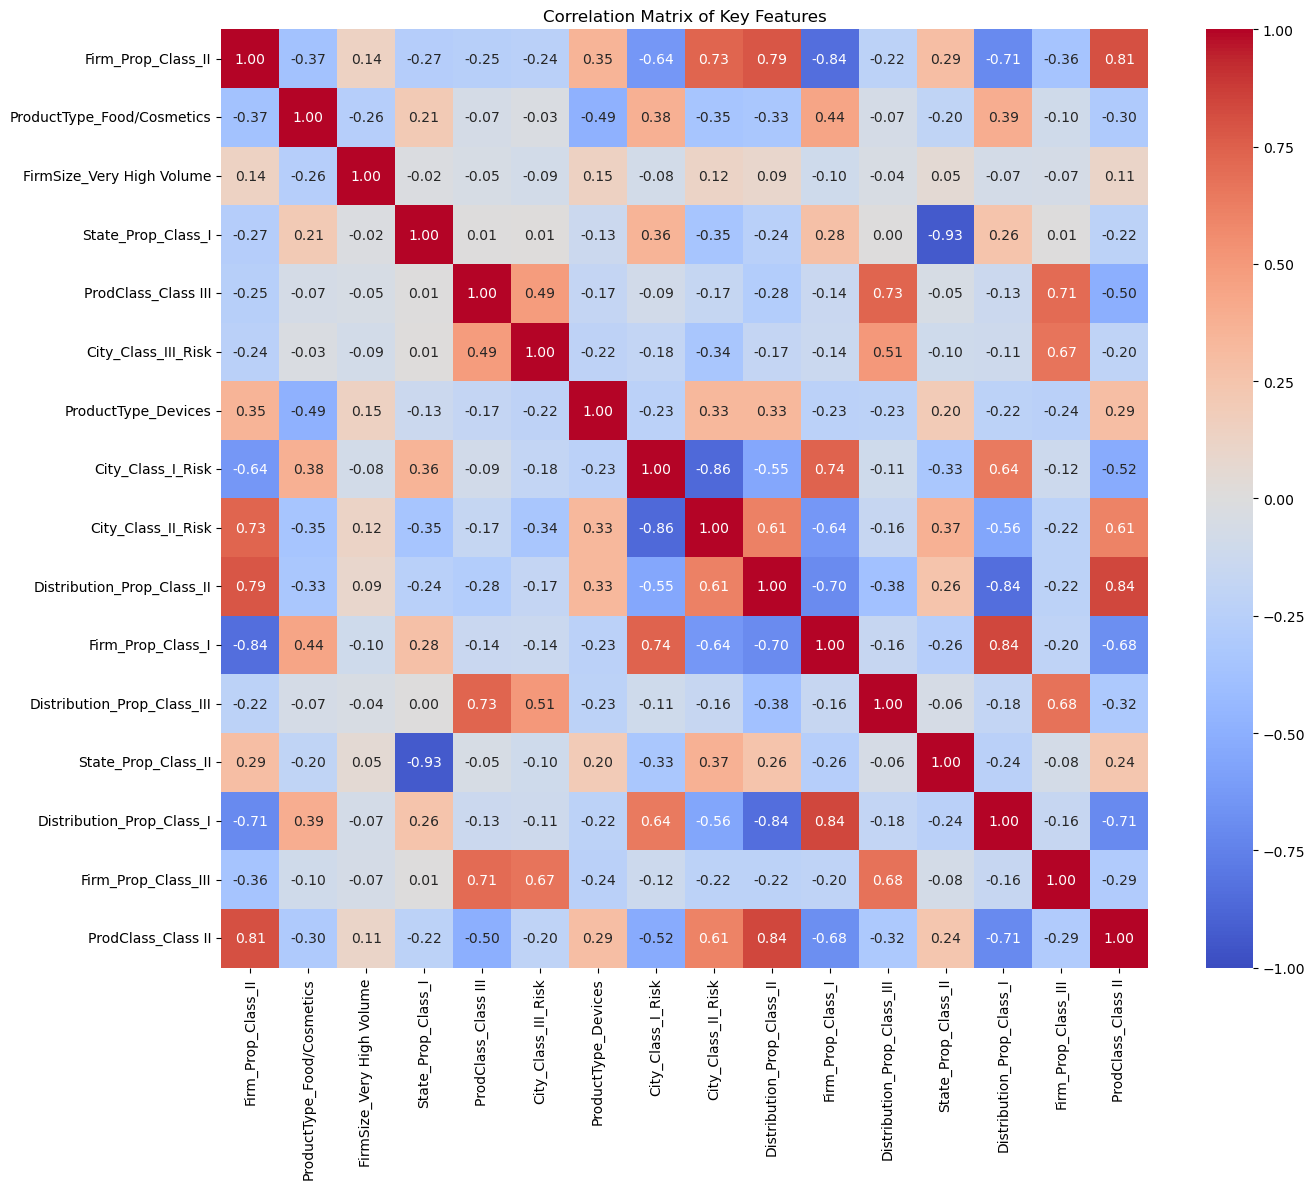

In [46]:
# Create correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix.loc[top_features, top_features], 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            vmin=-1,
            vmax=1,
            fmt='.2f')
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.show()

# Step 8: FINAL CLEANUP SECTION - Drop all original columns now that feature engineering is complete

In [47]:
# Identify original columns to drop
original_cols_to_drop = [
    # ID variables
    "FEI Number", "Event ID", "Product ID", "Recall Details",
    # Original columns that have been transformed
    "Center", "Center Classification Date",
    "Recalling Firm Name", "Distribution Pattern",
    "Recalling Firm City", "Recalling Firm State", "Recalling Firm Country",
    "Product Type", "Status",
    # Text columns that will be processed separately for the hybrid dataset
    "Reason for Recall", "Product Description",
    # Original categorical column now fully dummy encoded
    "Product Classification",
    # Intermediate columns
    "Region", "Firm_Size_Category", "City_Size_Category"
]

# Filter to only include columns that exist
cols_to_drop = [col for col in original_cols_to_drop if col in df_processed.columns]

# Drop the columns
df_processed_baseline = df_processed.drop(columns=cols_to_drop)
print("\nCleaned up original and intermediate columns:")
print(f"Dropped columns: {cols_to_drop}")
print(f"Baseline shape: {df_processed_baseline.shape}")


Cleaned up original and intermediate columns:
Dropped columns: ['FEI Number', 'Event ID', 'Product ID', 'Recall Details', 'Center', 'Center Classification Date', 'Recalling Firm Name', 'Distribution Pattern', 'Recalling Firm City', 'Recalling Firm State', 'Recalling Firm Country', 'Product Type', 'Status', 'Reason for Recall', 'Product Description', 'Product Classification', 'Region', 'Firm_Size_Category', 'City_Size_Category']
Baseline shape: (95082, 48)


In [48]:
# Preview Baseline dataset columns
print("\nBaseline dataset columns:")
print(df_processed_baseline.columns.tolist())


Baseline dataset columns:
['Event Classification', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Years_Since_First', 'Year_Scaled', 'Firm_Recall_Count', 'Firm_Prop_Class_I', 'Firm_Prop_Class_II', 'Firm_Prop_Class_III', 'Distribution_Pattern_Count', 'Distribution_Prop_Class_I', 'Distribution_Prop_Class_II', 'Distribution_Prop_Class_III', 'State_Recall_Count', 'State_Prop_Class_I', 'State_Prop_Class_II', 'State_Prop_Class_III', 'City_Recall_Count', 'City_Class_I_Risk', 'City_Class_II_Risk', 'City_Class_III_Risk', 'Region_Midwest', 'Region_Northeast', 'Region_Other', 'Region_South', 'Region_West', 'Is_US', 'ProdClass_Class II', 'ProdClass_Class III', 'ProductType_Devices', 'ProductType_Drugs', 'ProductType_Food/Cosmetics', 'ProductType_Tobacco', 'ProductType_Veterinary', 'Status_Ongoing', 'Status_Terminated', 'FirmSize_Low Volume', 'FirmSize_Medium Volume', 'FirmSize_Very High Volume', 'FirmSize_Very Low Volume', 'CitySize_Medium', 'CitySize_Small', '

# Step 9: Advanced Text Feature Extraction for 'Reason for Recall' and 'Product Description'

In [49]:
df_processed_text = df.copy()

In [50]:
# Text cleaning function
def text_cleaner(text):
    if not isinstance(text, str):
        return ""
        
    # Convert to lowercase and remove special characters
    text = re.sub(r'[^\w\s]', ' ', str(text).lower())
    
    # Remove numbers but keep important regulatory codes intact
    text = re.sub(r'\b\d+\b(?!\s*cfr|\s*usc|\s*fda)', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove control characters and encoding artifacts
    text = re.sub(r'\*x[0-9a-f]{4}\*', ' ', text)
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', ' ', text)
    
    # Normalize common terms
    text = re.sub(r'\b(upc|sku|item|code|number)s?\b', 'product_code', text.lower())
    text = re.sub(r'\b(possible|potential|may|might|could)\b', 'potential', text)
    
    # Group measurement units (optional - remove if not relevant)
    text = re.sub(r'\b\d+\s*(oz|ml|mg|g)\b', 'quantity_measure', text)
    
    # Remove FDA-specific stopwords in addition to standard ones
    try:
        stop_words = set(stopwords.words('english'))
    except:
        stop_words = english_stopwords
        
    fda_stopwords = {'recalled', 'recalling', 'firm', 'product', 'products', 'recall', 
                     'various', 'due', 'manufactured'}
    all_stopwords = stop_words.union(fda_stopwords)
    
    tokens = text.split()
    filtered_tokens = [w for w in tokens if w not in all_stopwords]
    
    return ' '.join(filtered_tokens)

In [51]:
# Apply the cleaning function
df_processed_text['reason_cleaned'] = df_processed_text['Reason for Recall'].apply(text_cleaner)
df_processed_text['description_cleaned'] = df_processed_text['Product Description'].apply(text_cleaner)

In [52]:
# Combine both text fields with different weights
df_processed_text['combined_text'] = df_processed_text['reason_cleaned'] + ' ' + df_processed_text['description_cleaned']

In [53]:
# Create TF-IDF features with n-grams
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,                   # Ignore terms that appear in fewer than 5 documents
    max_df=0.7,                 # Ignore terms that appear in more than 70% of documents
    ngram_range=(1, 2),         # Include unigrams and bigrams
    use_idf=True,
    sublinear_tf=True           # Apply sublinear tf scaling (1 + log(tf))
)

In [54]:
# Apply TF-IDF transformation
tfidf_matrix = tfidf_vectorizer.fit_transform(df_processed_text['combined_text'])

In [55]:
# Get the most important features for interpretability
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of TF-IDF features created: {len(feature_names)}")

Number of TF-IDF features created: 5000


Top 20 TF-IDF features:

In [56]:
# Calculate feature importance by summing TF-IDF values across documents
feature_importance = tfidf_matrix.sum(axis=0).A1
top_indices = feature_importance.argsort()[-20:][::-1]
top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]
for feature, importance in top_features:
    print(f"  {feature}: {importance:.2f}")

  _x000d_: 3495.27
  product_code: 2750.71
  potential: 2676.18
  blood: 2313.90
  distributed: 2091.84
  _x000d_ _x000d_: 1958.80
  oz: 1629.56
  quantity_measure: 1587.05
  ml: 1466.84
  donor: 1319.70
  inc: 1197.64
  system: 1185.05
  sterility: 1172.92
  rx: 1165.25
  ndc: 1164.09
  use: 1158.53
  red: 1147.64
  reduced: 1146.81
  net: 1112.10
  collected: 1103.72


In [57]:
# Apply dimensionality reduction
n_components = min(300, tfidf_matrix.shape[1] - 1)  # Ensure valid number of components
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_svd = svd.fit_transform(tfidf_matrix)

In [58]:
# Calculate explained variance
explained_var = svd.explained_variance_ratio_.sum()
print(f"Explained variance from {n_components} SVD components: {explained_var:.2f}")

Explained variance from 300 SVD components: 0.48


In [59]:
# Create DataFrame with the reduced features
text_features_df = pd.DataFrame(
    tfidf_svd, 
    columns=[f'text_svd_{i}' for i in range(n_components)]
)

In [60]:
# Transfer the 'Product Classification' column to text_features_df for class-specific processing
text_features_df['Product Classification'] = df_processed_text['Product Classification']

In [61]:
# Add the combined_text column to text_features_df
text_features_df['combined_text'] = df_processed_text['combined_text']

In [62]:
# Create product-class-specific text features
for prod_class in text_features_df['Product Classification'].unique():
    class_idx = text_features_df['Product Classification'] == prod_class
    class_freq = text_features_df[class_idx]['combined_text'].str.split().explode().value_counts().head(50)
    class_specific_terms = set(class_freq.index)
    
    # Create a binary feature for presence of class-specific terms
    safe_class_name = prod_class.replace(" ", "_").replace("/", "_")
    text_features_df[f'has_{safe_class_name}_terms'] = text_features_df['combined_text'].apply(
        lambda x: any(term in str(x).split() for term in class_specific_terms)
    ).astype(int)

In [63]:
# Remove the temporary columns used for processing
text_features_df = text_features_df.drop(columns=['Product Classification', 'combined_text'])

In [64]:
# Add the text features to the processed dataframe
df_processed_hybrid = pd.concat([df_processed_baseline, text_features_df], axis=1)

In [65]:
# Shape
print(f"\nHybrid dataset shape: {df_processed_hybrid.shape}")

# Preview Hybrid dataset columns
print("\nHybrid dataset columns:")
print(df_processed_hybrid.columns.tolist())


Hybrid dataset shape: (95082, 351)

Hybrid dataset columns:
['Event Classification', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Years_Since_First', 'Year_Scaled', 'Firm_Recall_Count', 'Firm_Prop_Class_I', 'Firm_Prop_Class_II', 'Firm_Prop_Class_III', 'Distribution_Pattern_Count', 'Distribution_Prop_Class_I', 'Distribution_Prop_Class_II', 'Distribution_Prop_Class_III', 'State_Recall_Count', 'State_Prop_Class_I', 'State_Prop_Class_II', 'State_Prop_Class_III', 'City_Recall_Count', 'City_Class_I_Risk', 'City_Class_II_Risk', 'City_Class_III_Risk', 'Region_Midwest', 'Region_Northeast', 'Region_Other', 'Region_South', 'Region_West', 'Is_US', 'ProdClass_Class II', 'ProdClass_Class III', 'ProductType_Devices', 'ProductType_Drugs', 'ProductType_Food/Cosmetics', 'ProductType_Tobacco', 'ProductType_Veterinary', 'Status_Ongoing', 'Status_Terminated', 'FirmSize_Low Volume', 'FirmSize_Medium Volume', 'FirmSize_Very High Volume', 'FirmSize_Very Low Volume', 'Cit

# Step 10: Implementing Feature Selection using Wrapper Methods
Since highly correlated variables were identified in Step 7, use feature selection to create more parsimonious models by removing redundant or non-informative features. Split data into training and validation sets to avoid selection bias

In [66]:
# Define features and target variable
X = df_processed_hybrid.drop('Event Classification', axis=1)
y = df_processed_hybrid['Event Classification']

In [67]:
# Identify the unique classes
classes = np.unique(y)
n_classes = len(classes)
print(f"This is a {n_classes}-class classification problem with classes: {classes}")

This is a 3-class classification problem with classes: ['Class I' 'Class II' 'Class III']


In [68]:
# Create a train/validation split (80/20) while preserving class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                 random_state=42, 
                                                 stratify=y) # handles class imbalance

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (76065, 350)
Validation set shape: (19017, 350)


Implement Recursive Feature Elimination (RFE) and Apply Recursive Feature Elimination with Cross-Validation (RFECV)

In [69]:
# Define a custom multi-class ROC AUC scorer
def multi_class_roc_auc(y_true, y_pred_proba):
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    return roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')

multi_roc_auc_scorer = make_scorer(multi_class_roc_auc, needs_proba=True)

C:\Users\Dell\miniconda3\envs\demo8\lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Initialize a base model for feature selection

In [70]:
# Random Forest handles mixed data types
base_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

Set up RFE with cross-validation to find the optimal number of features

In [71]:
# Use 5-fold cross-validation and our custom multi-class ROC AUC as the scoring metric
rfecv = RFECV(
    estimator=base_model,
    step=5,  # Remove 5 features at each iteration to speed up the process
    cv=5,    # 5-fold cross-validation
    scoring=multi_roc_auc_scorer,
    min_features_to_select=10,  # Don't go below 10 features
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [72]:
# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

Fitting estimator with 350 features.
Fitting estimator with 345 features.
Fitting estimator with 340 features.
Fitting estimator with 335 features.
Fitting estimator with 330 features.
Fitting estimator with 325 features.
Fitting estimator with 320 features.
Fitting estimator with 315 features.
Fitting estimator with 310 features.
Fitting estimator with 305 features.
Fitting estimator with 300 features.
Fitting estimator with 295 features.
Fitting estimator with 290 features.
Fitting estimator with 285 features.
Fitting estimator with 280 features.
Fitting estimator with 275 features.
Fitting estimator with 270 features.
Fitting estimator with 265 features.
Fitting estimator with 260 features.
Fitting estimator with 255 features.
Fitting estimator with 250 features.
Fitting estimator with 245 features.
Fitting estimator with 240 features.
Fitting estimator with 235 features.
Fitting estimator with 230 features.
Fitting estimator with 225 features.
Fitting estimator with 220 features.
F

RFECV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
      min_features_to_select=10, n_jobs=-1,
      scoring=make_scorer(multi_class_roc_auc, response_method='predict_proba'),
      step=5, verbose=1)

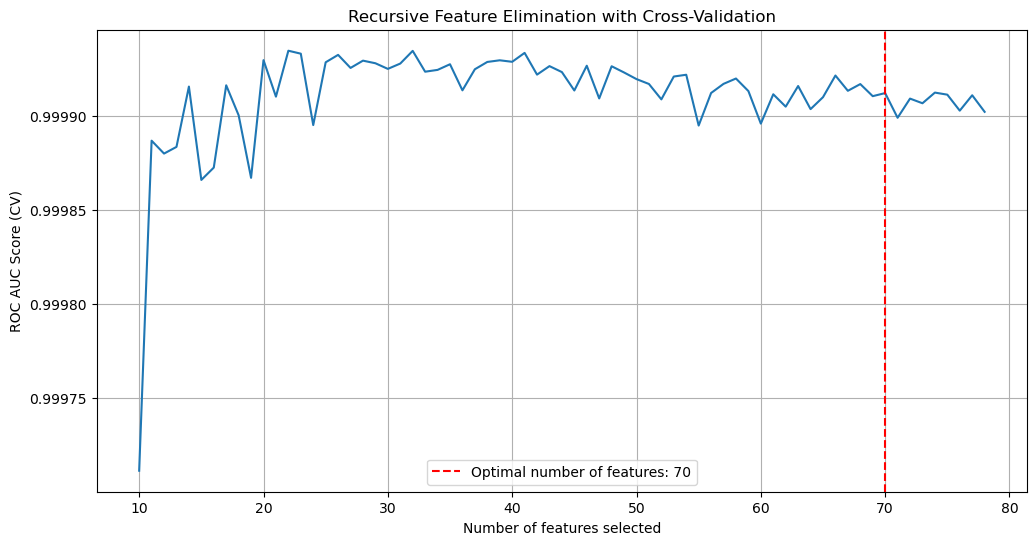

In [73]:
# Plot number of features vs. cross-validation scores
plt.figure(figsize=(12, 6))
plt.xlabel("Number of features selected")
plt.ylabel("ROC AUC Score (CV)")
plt.plot(range(rfecv.min_features_to_select, 
               len(rfecv.cv_results_["mean_test_score"]) + rfecv.min_features_to_select),
         rfecv.cv_results_["mean_test_score"])
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.axvline(x=rfecv.n_features_, color='r', linestyle='--', 
            label=f'Optimal number of features: {rfecv.n_features_}')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
# Get the selected features
selected_features = X_train.columns[rfecv.support_]
print(f"\nRFECV selected {rfecv.n_features_} optimal features out of {X_train.shape[1]}")


RFECV selected 70 optimal features out of 350


Evaluate the performance on validation set

In [75]:
# Train a model using only the selected features
model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
model_selected.fit(X_train[selected_features], y_train)

RandomForestClassifier(random_state=42)

In [76]:
# Predict on validation set with multi-class handling
y_pred_proba = model_selected.predict_proba(X_val[selected_features])
y_val_bin = label_binarize(y_val, classes=np.unique(y_train))
roc_auc = roc_auc_score(y_val_bin, y_pred_proba, multi_class='ovr', average='macro')
print(f"ROC AUC on validation set with {rfecv.n_features_} selected features: {roc_auc:.4f}")

ROC AUC on validation set with 70 selected features: 0.9998


In [77]:
# Compare with performance using all features
model_all = RandomForestClassifier(n_estimators=100, random_state=42)
model_all.fit(X_train, y_train)
y_pred_proba_all = model_all.predict_proba(X_val)
roc_auc_all = roc_auc_score(y_val_bin, y_pred_proba_all, multi_class='ovr', average='macro')
print(f"ROC AUC on validation set with all {X_train.shape[1]} features: {roc_auc_all:.4f}")

ROC AUC on validation set with all 350 features: 0.9998


Analyze class-specific performance

In [78]:
# Convert probabilities to class-specific binary scores
class_specific_auc = {}
for i, cls in enumerate(np.unique(y_train)):
    # For each class, calculate ROC AUC in one-vs-rest fashion
    y_val_binary = (y_val == cls).astype(int)
    y_pred_proba_class = y_pred_proba[:, i]
    auc = roc_auc_score(y_val_binary, y_pred_proba_class)
    class_specific_auc[cls] = auc
    
    # Also for the full model
    y_pred_proba_all_class = y_pred_proba_all[:, i]
    auc_all = roc_auc_score(y_val_binary, y_pred_proba_all_class)
    
    print(f"Class '{cls}':")
    print(f"  - ROC AUC with selected features: {auc:.4f}")
    print(f"  - ROC AUC with all features: {auc_all:.4f}")
    print(f"  - {'Improvement' if auc > auc_all else 'Decrease'} of {abs(auc - auc_all):.4f}")

Class 'Class I':
  - ROC AUC with selected features: 0.9999
  - ROC AUC with all features: 0.9999
  - Improvement of 0.0001
Class 'Class II':
  - ROC AUC with selected features: 0.9998
  - ROC AUC with all features: 0.9998
  - Decrease of 0.0000
Class 'Class III':
  - ROC AUC with selected features: 0.9998
  - ROC AUC with all features: 0.9998
  - Decrease of 0.0001


Analyze feature importance of selected features

In [79]:
# Get feature importances
importances = model_selected.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("\nFeature ranking of selected features:")
for i, idx in enumerate(indices[:20]):  # Show top 20 or all if less
    print(f"{i+1}. {selected_features[idx]} ({importances[idx]:.4f})")


Feature ranking of selected features:
1. ProdClass_Class II (0.2147)
2. Distribution_Prop_Class_I (0.1389)
3. Distribution_Prop_Class_II (0.1102)
4. Firm_Prop_Class_II (0.0939)
5. Firm_Prop_Class_I (0.0934)
6. ProdClass_Class III (0.0928)
7. Distribution_Prop_Class_III (0.0404)
8. Firm_Prop_Class_III (0.0285)
9. City_Class_I_Risk (0.0209)
10. City_Class_II_Risk (0.0150)
11. ProductType_Food/Cosmetics (0.0103)
12. text_svd_3 (0.0082)
13. text_svd_2 (0.0076)
14. City_Class_III_Risk (0.0070)
15. text_svd_24 (0.0053)
16. text_svd_22 (0.0053)
17. Distribution_Pattern_Count (0.0051)
18. text_svd_0 (0.0037)
19. ProductType_Devices (0.0036)
20. text_svd_19 (0.0035)


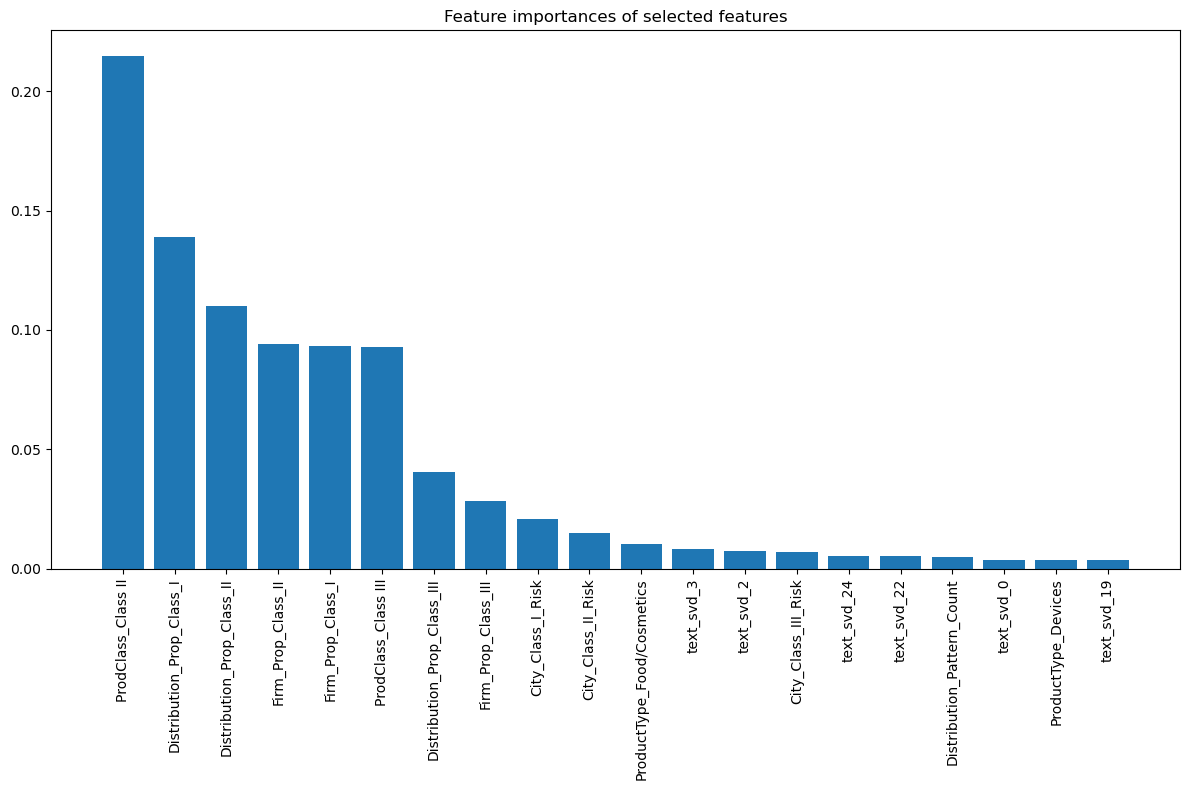

In [80]:
# Plot top 20 feature importances (or all if less than 20)
plt.figure(figsize=(12, 8))
plt.title("Feature importances of selected features")
plt.bar(range(min(20, len(indices))), 
        importances[indices[:min(20, len(indices))]], 
        align="center")
plt.xticks(range(min(20, len(indices))), 
           [selected_features[i] for i in indices[:min(20, len(indices))]], 
           rotation=90)
plt.tight_layout()
plt.show()

Create a dataset with only selected features for future modeling

In [81]:
df_processed_selected = df_processed_hybrid[list(selected_features) + ['Event Classification']]
print(f"Selected features dataset shape: {df_processed_selected.shape}")

Selected features dataset shape: (95082, 71)


In [82]:
# Save dataset with selected features
df_processed_selected.to_csv('../data/processed_recalls_data_selected.csv', index=False)
print("Selected features dataset saved to '../data/processed_recalls_data_selected.csv'")

Selected features dataset saved to '../data/processed_recalls_data_selected.csv'


Applying feature selection to baseline dataset

In [72]:
# Define features and target for baseline dataset
X_baseline = df_processed_baseline.drop('Event Classification', axis=1)
y_baseline = df_processed_baseline['Event Classification']

In [73]:
# Split baseline data
X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(
    X_baseline, y_baseline, test_size=0.2, random_state=42, stratify=y_baseline)

Fit RFECV model on baseline dataset

In [74]:
# RFECV for baseline
rfecv_baseline = RFECV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    step=1,  # Smaller step due to fewer features
    cv=5,
    scoring=multi_roc_auc_scorer,
    min_features_to_select=5,
    n_jobs=-1,
    verbose=1
)

rfecv_baseline.fit(X_train_baseline, y_train_baseline)

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.


RFECV(cv=5, estimator=RandomForestClassifier(random_state=42),
      min_features_to_select=5, n_jobs=-1,
      scoring=make_scorer(multi_class_roc_auc, response_method='predict_proba'),
      verbose=1)

In [75]:
# Get selected baseline features
baseline_selected_features = X_train_baseline.columns[rfecv_baseline.support_]
print(f"\nRFECV selected {rfecv_baseline.n_features_} optimal features out of {X_train_baseline.shape[1]} baseline features")


RFECV selected 42 optimal features out of 47 baseline features


In [76]:
# Create and save baseline selected dataset
df_processed_baseline_selected = df_processed_baseline[list(baseline_selected_features) + ['Event Classification']]
df_processed_baseline_selected.to_csv('../data/processed_recalls_data_baseline_selected.csv', index=False)
print("Baseline selected features dataset saved to '../data/processed_recalls_data_baseline_selected.csv'")

Baseline selected features dataset saved to '../data/processed_recalls_data_baseline_selected.csv'
